In [1]:
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.feature_selection import (
    SequentialFeatureSelector,
)
from mlxtend.evaluate import feature_importance_permutation
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.utils.estimator_checks import check_estimator
from sklearn.model_selection import cross_val_predict, train_test_split
from sklearn.metrics import accuracy_score, f1_score, matthews_corrcoef
import matplotlib.ticker as ticker
import os
from pathlib import Path
import json

import sys

sys.path.append("scripts")

import utils
import distclassipy as dcpy

cd = dcpy.Distance()

In [2]:
with open("settings.txt") as f:
    settings_dict = json.load(f)
np.random.seed(settings_dict["seed_choice"])

classification_letter = "c"
classification_problem = settings_dict["classification_problem"][classification_letter]
classes_to_keep = settings_dict["classes_to_keep"][classification_letter]
results_subfolder = f"{classification_letter}. {classification_problem}"
sns_dict = settings_dict["sns_dict"]

sns.set_theme(**sns_dict)

In [3]:
# Load Data
X_df_FULL = pd.read_csv("data/X_df.csv", index_col=0)
y_df_FULL = pd.read_csv("data/y_df.csv", index_col=0)

In [4]:
#### NEW - load new data too and add

Xother = pd.read_csv("data/MARCHX_df.csv", index_col=0)
Xother = Xother.loc[~Xother.index.isin(X_df_FULL.index), X_df_FULL.columns]
yother = pd.read_csv("data/MARCHy_df.csv", index_col=0).loc[Xother.index]

# Xother = pd.read_csv("data/HIDDENX_df_multiclass.csv", index_col=0)
# Xother = Xother.loc[~Xother.index.isin(X_df_FULL.index), X_df_FULL.columns]
# yother = pd.read_csv("data/HIDDENy_df_multiclass.csv", index_col=0).loc[Xother.index]

X_df_FULL = pd.concat([X_df_FULL, Xother]).dropna()
y_df_FULL = pd.concat([y_df_FULL, yother]).loc[X_df_FULL.index]

In [5]:
assert X_df_FULL.index.shape == y_df_FULL.index.shape

In [6]:
# Remove manually selected 'bad' features
with open(os.path.join("results", results_subfolder, "drop_features.txt")) as f:
    bad_features = json.load(f)  # manually selected

X_df_FULL = X_df_FULL.drop(bad_features, axis=1)

print(X_df_FULL.shape[1])

31


In [7]:
# Keep only current classes
cl_keep_str = "_".join(classes_to_keep)

y_df_FULL = y_df_FULL[y_df_FULL["class"].isin(classes_to_keep)]
X_df_FULL = X_df_FULL.loc[y_df_FULL.index]

In [8]:
all_metrics = [
    "euclidean",
    # "braycurtis",
    # "canberra",
    # "cityblock",
    # "chebyshev",
    # cd.clark,
    # "correlation",
    # "cosine",
    # cd.hellinger,
    # cd.jaccard,
    # cd.lorentzian,
    # cd.marylandbridge,
    # cd.meehl,
    # cd.motyka,
    # cd.soergel,
    # cd.wave_hedges,
    # cd.kulczynski,
    # cd.add_chisq,
]

scoring = "f1_macro"
feats_to_keep = X_df_FULL.columns

feats_top_plot = 15
### For plotting only - how many features to plot in relative importance

---
# LOOP


Metric:   0%|          | 0/1 [00:00<?, ?it/s]

******************** Euclidean ********************


Run Number:   0%|          | 0/10 [00:00<?, ?it/s]

********** Run 1 **********
Euclidean: Selected 2 features: ['Period_band_r', 'Harmonics_mag_1_r']
F1 = 86.65 %
Accuracy = 86.38 %
Matthew's Coefficient = 82.46 %


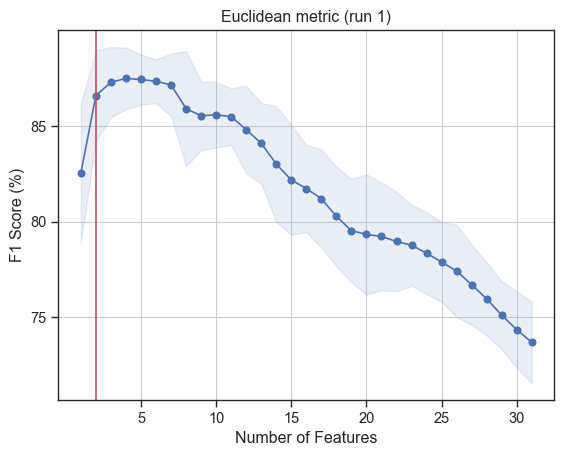

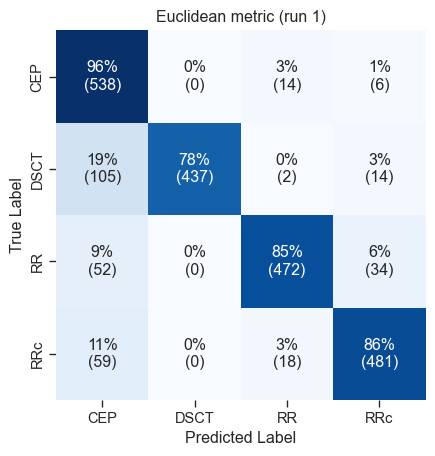

********** Run 2 **********
Euclidean: Selected 9 features: ['MHPS_ratio_r', 'Period_band_r', 'Psi_eta_r', 'Harmonics_mag_1_r', 'Harmonics_mag_7_r', 'Harmonics_phase_2_r', 'Amplitude_r', 'AndersonDarling_r', 'IAR_phi_r']
F1 = 82.01 %
Accuracy = 81.23 %
Matthew's Coefficient = 76.42 %


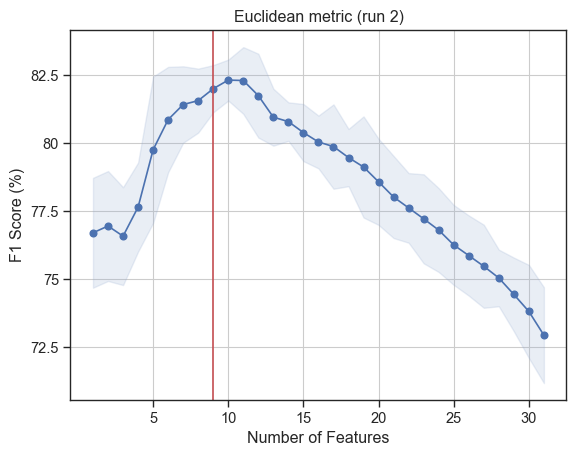

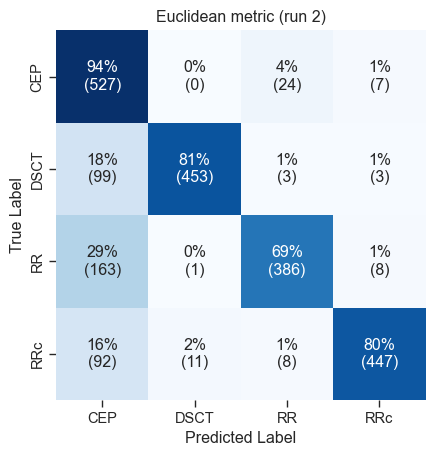

********** Run 3 **********
Euclidean: Selected 2 features: ['Period_band_r', 'IAR_phi_r']
F1 = 84.62 %
Accuracy = 84.23 %
Matthew's Coefficient = 79.92 %


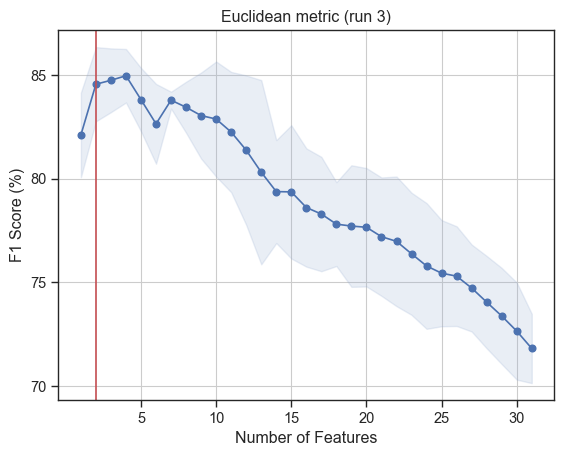

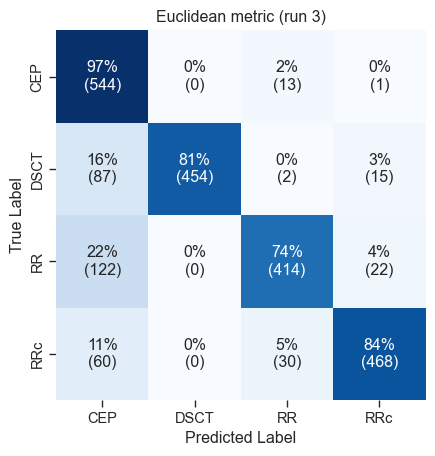

********** Run 4 **********
Euclidean: Selected 1 features: ['Period_band_r']
F1 = 84.44 %
Accuracy = 84.14 %
Matthew's Coefficient = 79.67 %


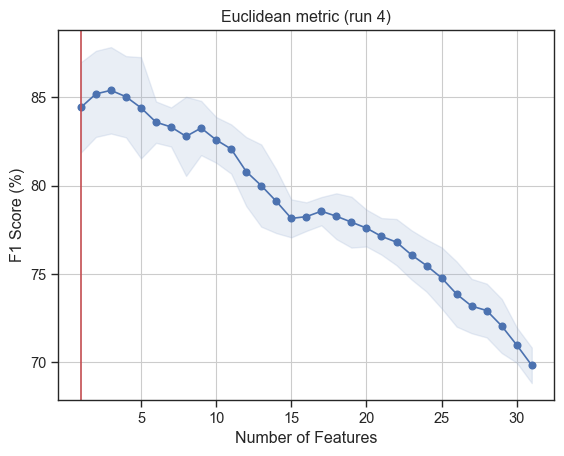

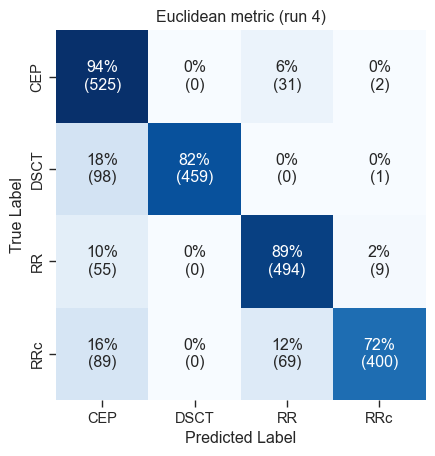

********** Run 5 **********
Euclidean: Selected 2 features: ['Period_band_r', 'Psi_eta_r']
F1 = 84.44 %
Accuracy = 84.09 %
Matthew's Coefficient = 79.53 %


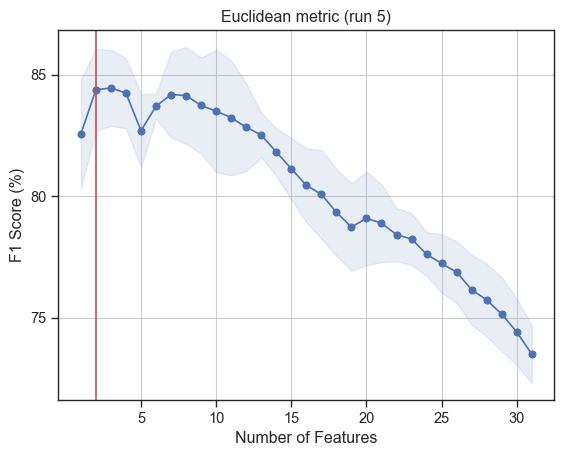

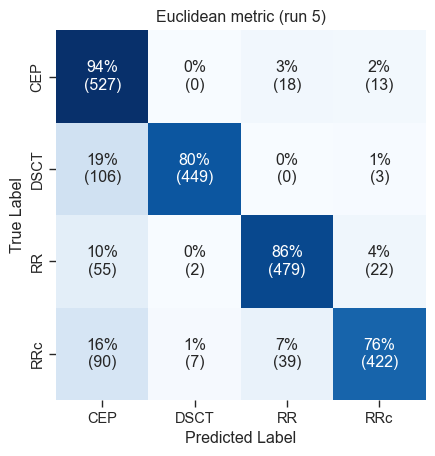

********** Run 6 **********
Euclidean: Selected 1 features: ['Period_band_r']
F1 = 86.95 %
Accuracy = 86.56 %
Matthew's Coefficient = 82.74 %


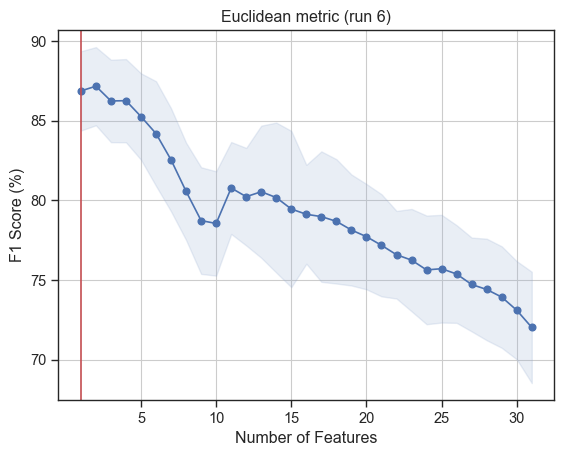

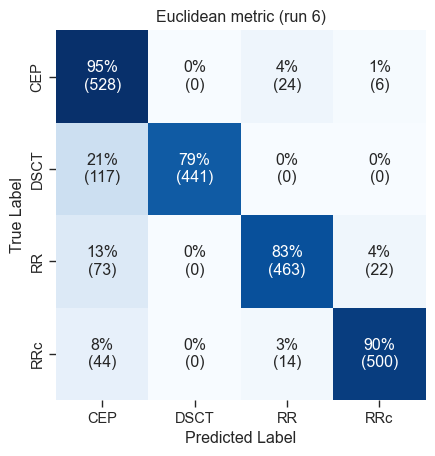

********** Run 7 **********
Euclidean: Selected 2 features: ['Period_band_r', 'IAR_phi_r']
F1 = 85.39 %
Accuracy = 85.13 %
Matthew's Coefficient = 81.07 %


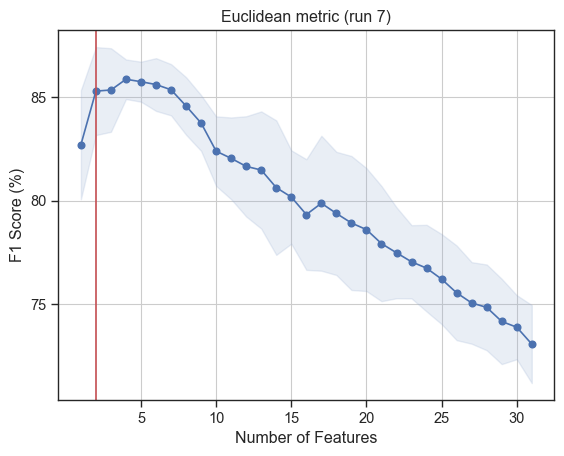

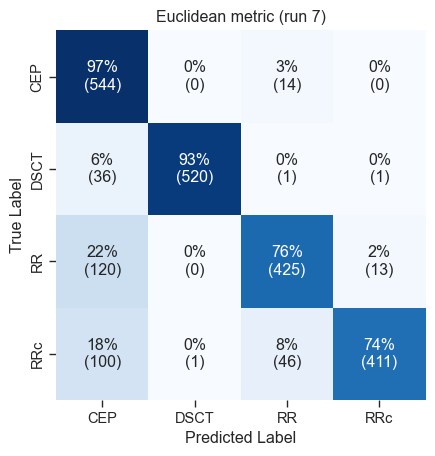

********** Run 8 **********
Euclidean: Selected 1 features: ['Period_band_r']
F1 = 87.26 %
Accuracy = 86.96 %
Matthew's Coefficient = 83.22 %


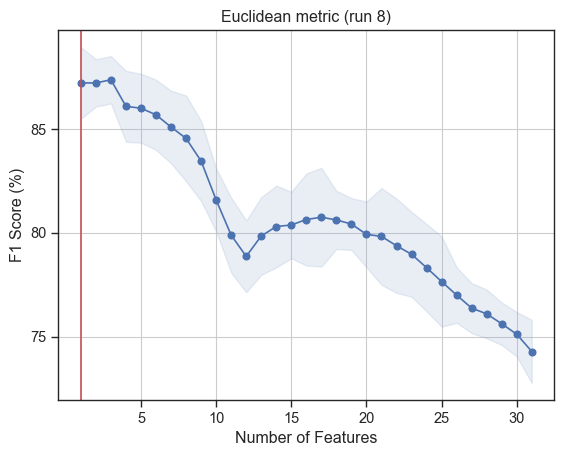

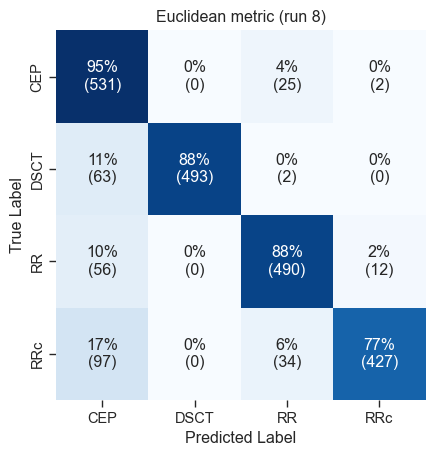

********** Run 9 **********
Euclidean: Selected 1 features: ['Period_band_r']
F1 = 82.38 %
Accuracy = 82.21 %
Matthew's Coefficient = 77.74 %


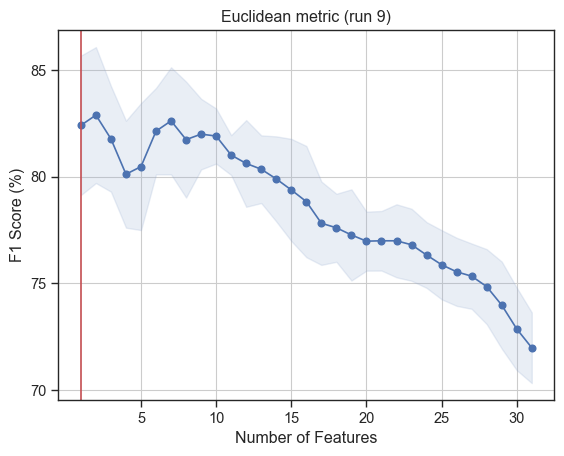

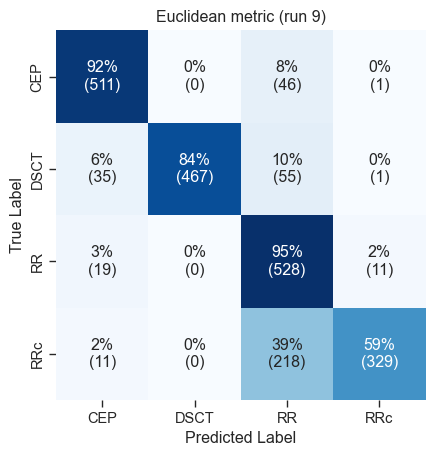

********** Run 10 **********
Euclidean: Selected 1 features: ['Period_band_r']
F1 = 81.85 %
Accuracy = 81.36 %
Matthew's Coefficient = 76.75 %


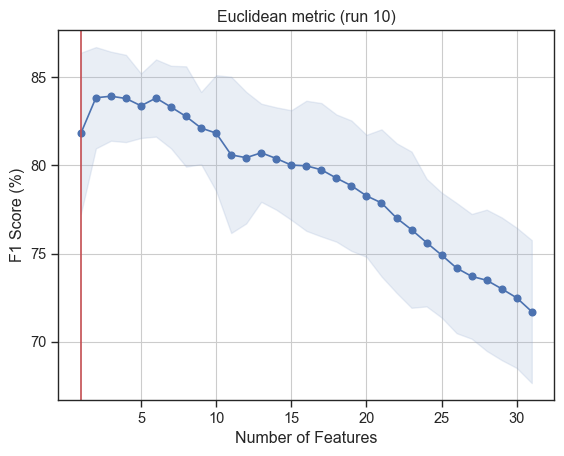

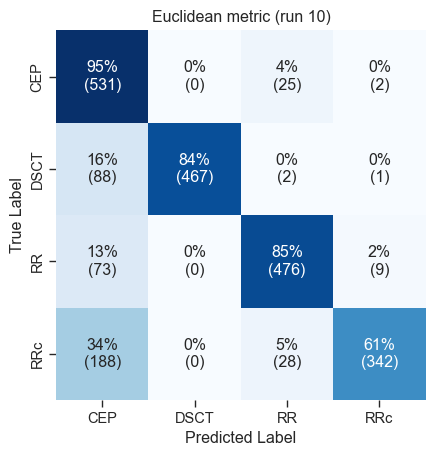

In [9]:
results_dict = {}
for metric in tqdm(all_metrics, desc="Metric", leave=True):
    metric_str = utils.get_metric_name(metric)
    # locpath = os.path.join("results", results_subfolder, "distclassipy", metric_str)
    print("*" * 20, metric_str, "*" * 20)

    results_dict[metric_str] = {}

    for run_num in tqdm(range(1, 11), desc="Run Number", leave=False):


        #### NEW - choose 558 from each class
        y_df = y_df_FULL.groupby("class").sample(n=558).sample(frac=1) # Last sample for shuffling
        X_df = X_df_FULL.loc[y_df.index]
        X = X_df.to_numpy()
        y = y_df.to_numpy().ravel()
        assert X.shape[0]==y.shape[0]
        
        results_dict[metric_str][run_num] = {}

        print("*" * 10, f"Run {run_num}", "*" * 10)

        # Sequential Feature Selection 1-31 features   
        lcdc = dcpy.DistanceMetricClassifier(
            metric=metric, scale_std=True, calculate_kde=False, calculate_1d_dist=False
        )
    
        feat_selector = SequentialFeatureSelector(
            lcdc,
            k_features=X_df_FULL.shape[1],
            scoring=scoring,
            forward=True,
            n_jobs=-1,
            verbose=0,
        ).fit(X_df.loc[:, feats_to_keep], y)
    
        res_df = pd.DataFrame.from_dict(feat_selector.get_metric_dict()).T
        res_df.index.name = "num_feats"
        res_df["avg_score"] = res_df["avg_score"].astype("float")
        res_df = res_df.sort_values(by="avg_score", ascending=False)
        res_df.to_csv(f"TEMPsfs_allfeatures.csv")

    
        # Reloading to
        sfs_df = pd.read_csv(f"TEMPsfs_allfeatures.csv", index_col=0)
        feats_idx, feats = utils.load_best_features(sfs_df)
    
        print(f"{metric_str}: Selected {len(feats)} features: {feats}")
        results_dict[metric_str][run_num]["selected_feats"] = len(feats)
    
        # Using the Selected Feature Subset For Making New Predictions
    
        # Cross validation
        lcdc = dcpy.DistanceMetricClassifier(
            metric=metric, scale_std=True, calculate_kde=False, calculate_1d_dist=False
        )
        X_sfs = X[:, feats_idx]
        y_pred = cross_val_predict(lcdc, X_sfs, y, cv=5, n_jobs=-1)
    
        acc = accuracy_score(y, y_pred)
        f1score = f1_score(y, y_pred, average="macro")
        matthew_coef = matthews_corrcoef(y, y_pred)

        results_dict[metric_str][run_num]["acc"] = acc
        results_dict[metric_str][run_num]["f1score"] = f1score
        results_dict[metric_str][run_num]["matthew_coef"] = matthew_coef
        results_dict[metric_str][run_num]["features"] = feats
        
        dat = np.hstack([y_pred.reshape(-1, 1), y.reshape(-1, 1)])
        objs = X_df.index
        preds_best_df = pd.DataFrame(data=dat, columns=["y_pred", "y_true"], index=objs)
        # preds_best_df.to_csv(f"{locpath}/preds_best.csv")
    
        print(
            f"F1 = {f1score*100:.2f} %\nAccuracy = {acc*100:.2f} %\nMatthew's Coefficient = {matthew_coef*100:.2f} %"
        )

        fig1 = plot_sfs(
            feat_selector.get_metric_dict(),
            kind="std_dev",
            color=sns.color_palette()[0],
            bcolor="#93aad0",
            ylabel="F1 Score (%)",  # scoring
        )
    
        tick_freq = 5
        plt.xticks(
            [x for x in list(feat_selector.get_metric_dict().keys()) if x % tick_freq == 0]
        )
    
        # Temp fix to get % instead of 0-1 values
        axtemp = plt.gca()
        axtemp.yaxis.set_major_formatter(
            ticker.FuncFormatter(lambda x, pos: "{0:g}".format(x * 100))
        )
    
        plt.locator_params(axis="y", nbins=6)
        plt.title(f"{metric_str.title()} metric (run {run_num})")
        # plt.savefig(f"{locpath}/sfs_allfeatures_plot.pdf", bbox_inches="tight")

        plt.axvline(x=len(feats), color=sns.color_palette()[3], label="Selected features")
        # plt.legend()
        # plt.savefig(f"{locpath}/sfs_allfeatures_plot_marked.pdf", bbox_inches="tight")
        plt.show()

        ax = utils.plot_cm(y_true=y, y_pred=y_pred)
        ax.set_title(f"{metric_str.title()} metric (run {run_num})")
        # plt.savefig(f"{locpath}/sfs_best_confusion_matrix.pdf", bbox_inches="tight")
        plt.show()

In [11]:
# Flatten the dictionary
data = []
for method, values in results_dict.items():
    for key, val in values.items():
        val['metric'] = method
        val['run'] = key
        data.append(val)

# Convert to DataFrame
df = pd.DataFrame(data)
df = df.loc[:,['metric', 'run', 'f1score', 'acc', 'selected_feats', 'features', 'matthew_coef']]

In [34]:
print("Mean")
df.drop(["run"],axis=1).groupby("metric").mean(numeric_only=True)

Mean


,f1score,acc,selected_feats,matthew_coef
metric,,,,
Euclidean,0.845981,0.842294,2.2,0.79952


In [36]:
print("Std deviation")
df.drop(["run"],axis=1).groupby("metric").std(numeric_only=True)

Std deviation


,f1score,acc,selected_feats,matthew_coef
metric,,,,
Euclidean,0.020186,0.020989,2.440401,0.024463


In [37]:
df.to_csv("NB10Results.csv")